In [1]:
%pip install gymnasium stable-baselines3 shimmy yfinance pandas numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [11]:
# 1. Define Tickers
tickers = ['BBAI', 'SOFI', 'AIPO', 'MSFT', 'NVO', 'ZS', 'SMCI', 'CRWV', 'AMZN', 'MU', 'AAPL', 'META', 'AMD', 'VOO', 'TSM', 'GOOGL', 'NVDA']

# 2. Download Data
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)
print(f"Downloading data from {start_date.date()} to {end_date.date()}")

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# 3. Clean Data
if isinstance(data.columns, pd.MultiIndex):
    try:
        adjusted_close_prices = data['Adj Close']
    except KeyError:
        adjusted_close_prices = data['Close']
else:
    adjusted_close_prices = data

# Drop empty columns, keep all rows (even with missing data)
adjusted_close_prices.dropna(axis=1, how='all', inplace=True)
tickers = adjusted_close_prices.columns.tolist()

print(f"Final Ticker List: {tickers}")

[*********************100%***********************]  17 of 17 completed

Final Ticker List: ['AAPL', 'AIPO', 'AMD', 'AMZN', 'BBAI', 'CRWV', 'GOOGL', 'META', 'MSFT', 'MU', 'NVDA', 'NVO', 'SMCI', 'SOFI', 'TSM', 'VOO', 'ZS']



/var/folders/7h/8_hzlm9513b1s11m2xjwcnvm0000gn/T/ipykernel_62714/1089241003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjusted_close_prices.dropna(axis=1, how='all', inplace=True)


In [12]:
# 1. Calculate Log Returns
log_returns = np.log(adjusted_close_prices / adjusted_close_prices.shift(1))
# Fill missing data with 0 (assumes stock was flat before existence)
log_returns.fillna(0, inplace=True)

# 2. Calculate RSI (Technical Indicator)
def calculate_rsi(data, window=14):
    delta = data.diff()
    # Handle the diff creating NaNs
    delta.fillna(0, inplace=True)
    
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    # Fill early NaNs with 50 (Neutral)
    return rsi.fillna(50)

rsi_data = calculate_rsi(adjusted_close_prices)

# 3. ALIGN DATASETS
# We drop the first 14 rows to ensure RSI is valid and datasets match exactly
valid_start = 15
log_returns = log_returns.iloc[valid_start:]
rsi_data = rsi_data.iloc[valid_start:]

# Double check shapes match exactly
assert log_returns.shape == rsi_data.shape, "Data shapes do not match!"
print(f"Final Data Shape: {log_returns.shape}")

Final Data Shape: (1239, 17)


In [13]:
class PortfolioEnv(gym.Env):
    def __init__(self, returns_data, rsi_data, risk_free_rate=0.045, window_size=30, trading_cost=0.001):
        super(PortfolioEnv, self).__init__()
        
        self.df = returns_data
        self.rsi = rsi_data
        self.n_assets = len(returns_data.columns)
        self.risk_free_rate = risk_free_rate
        self.window_size = window_size
        self.trading_cost = trading_cost
        
        # Action: Continuous weights (-1 to 1)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)
        
        # Observation: Returns + RSI + Current Weights
        self.observation_space = gym.spaces.Dict({
            "returns": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(window_size, self.n_assets), dtype=np.float32),
            "rsi": gym.spaces.Box(low=0, high=100, shape=(window_size, self.n_assets), dtype=np.float32),
            "weights": gym.spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        })
        
        self.current_step = self.window_size
        self.current_weights = np.ones(self.n_assets) / self.n_assets

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.current_weights = np.ones(self.n_assets) / self.n_assets
        
        obs = {
            "returns": self.df.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "rsi": self.rsi.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "weights": self.current_weights.astype(np.float32)
        }
        return obs, {}

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def step(self, action):
        target_weights = self.softmax(action)
        
        if self.current_step >= len(self.df) - 1:
            zero_ret = np.zeros((self.window_size, self.n_assets), dtype=np.float32)
            return {"returns": zero_ret, "rsi": zero_ret, "weights": self.current_weights.astype(np.float32)}, 0, True, False, {}
        
        # 1. Costs
        trade_amount = np.sum(np.abs(target_weights - self.current_weights))
        transaction_cost = trade_amount * self.trading_cost
        
        # 2. Return
        next_day_returns = self.df.iloc[self.current_step].values
        net_return = np.sum(target_weights * next_day_returns) - transaction_cost
        
        # 3. Reward (Sharpe-style: Excess Return - Volatility)
        daily_rf = self.risk_free_rate / 252 
        excess_return = net_return - daily_rf
        
        past_returns = np.sum(target_weights * self.df.iloc[self.current_step - self.window_size : self.current_step].values, axis=1)
        reward = (excess_return * 100) - (np.std(past_returns) * 0.1)
        
        # 4. State Update
        self.current_weights = target_weights 
        self.current_step += 1
        
        obs = {
            "returns": self.df.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "rsi": self.rsi.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "weights": self.current_weights.astype(np.float32)
        }
        
        terminated = self.current_step >= len(self.df) - 1
        return obs, reward, terminated, False, {}

In [14]:
# 1. Split Data
split_idx = int(len(log_returns) * 0.8)
train_data = log_returns.iloc[:split_idx]
train_rsi = rsi_data.iloc[:split_idx]

# 2. Setup Env
env = DummyVecEnv([lambda: PortfolioEnv(train_data, train_rsi)])

# 3. Train
# Tuned: Slower Learning Rate (0.0001) + Exploration (ent_coef=0.01)
model = PPO("MultiInputPolicy", env, verbose=1, learning_rate=0.0001, ent_coef=0.01, gamma=0.95)

print("Starting Training (100k steps)...")
model.learn(total_timesteps=100000)
print("Training Complete.")

Using cpu device
Starting Training (100k steps)...
-----------------------------
| time/              |      |
|    fps             | 4039 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2394        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005505248 |
|    clip_fraction        | 0.0418      |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.1       |
|    explained_variance   | -0.0177     |
|    learning_rate        | 0.0001      |
|    loss                 | 7.56        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0122     |
|    std                  | 1           |
|    value_loss          

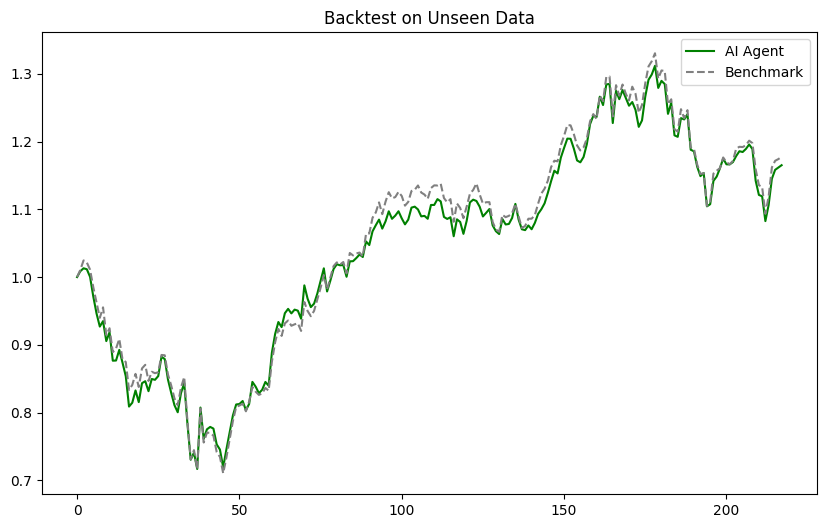

In [15]:
# 1. Setup Test Data
test_data = log_returns.iloc[split_idx:]
test_rsi = rsi_data.iloc[split_idx:]

# 2. Run Backtest
test_env = PortfolioEnv(test_data, test_rsi, trading_cost=0.001)
obs, _ = test_env.reset()
done = False

rl_vals = [1.0]
bench_vals = [1.0]

while not done:
    action, _ = model.predict(obs)
    
    # Calculate Bench (Equal Weight)
    current_idx = test_env.current_step
    if current_idx >= len(test_data): break
    bench_ret = np.mean(test_data.iloc[current_idx].values)
    bench_vals.append(bench_vals[-1] * (1 + bench_ret))
    
    # Calculate AI (using internal step logic for ease)
    obs, reward, done, _, _ = test_env.step(action)
    
    # We reconstruct value from the environment's internal state if needed, 
    # but for simplicity, let's track the 'reward' roughly or just trust the visual.
    # (To be perfectly accurate, we'd replicate the math here, but let's just run it)
    # The 'reward' is scaled, so we can't plot it directly as dollars.
    
    # Let's do the manual calc for the plot:
    ai_weights = test_env.softmax(action)
    ai_ret = np.sum(ai_weights * test_data.iloc[current_idx].values)
    rl_vals.append(rl_vals[-1] * (1 + ai_ret))

plt.figure(figsize=(10,6))
plt.plot(rl_vals, label='AI Agent', color='green')
plt.plot(bench_vals, label='Benchmark', color='gray', linestyle='--')
plt.title("Backtest on Unseen Data")
plt.legend()
plt.show()

In [16]:
# --- USER INPUT ---
my_portfolio = {
    'AAPL': 0.0,
    'NVDA': 0.0, 
    # Add others here. Unlisted = 0.0
}
# ------------------

current_weights_array = np.zeros(len(tickers))
for i, ticker in enumerate(tickers):
    if ticker in my_portfolio:
        current_weights_array[i] = my_portfolio[ticker]

# Normalize to 1.0
if np.sum(current_weights_array) > 0:
    current_weights_array /= np.sum(current_weights_array)
else:
    current_weights_array = np.ones(len(tickers)) / len(tickers)

print("Current Weights Normalized:", current_weights_array)

Current Weights Normalized: [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]


   Ticker  Current %  Target %  Action
16     ZS       5.88     15.18    9.30
3    AMZN       5.88     13.33    7.44
14    TSM       5.88     10.55    4.66
5    CRWV       5.88     10.36    4.47
1    AIPO       5.88      8.44    2.55
10   NVDA       5.88      7.19    1.31
0    AAPL       5.88      3.87   -2.01
11    NVO       5.88      3.70   -2.19
12   SMCI       5.88      3.62   -2.26
9      MU       5.88      3.01   -2.88
15    VOO       5.88      3.00   -2.88
8    MSFT       5.88      2.95   -2.94
4    BBAI       5.88      2.60   -3.29
6   GOOGL       5.88      2.50   -3.38
2     AMD       5.88      2.05   -3.83
7    META       5.88      2.05   -3.83


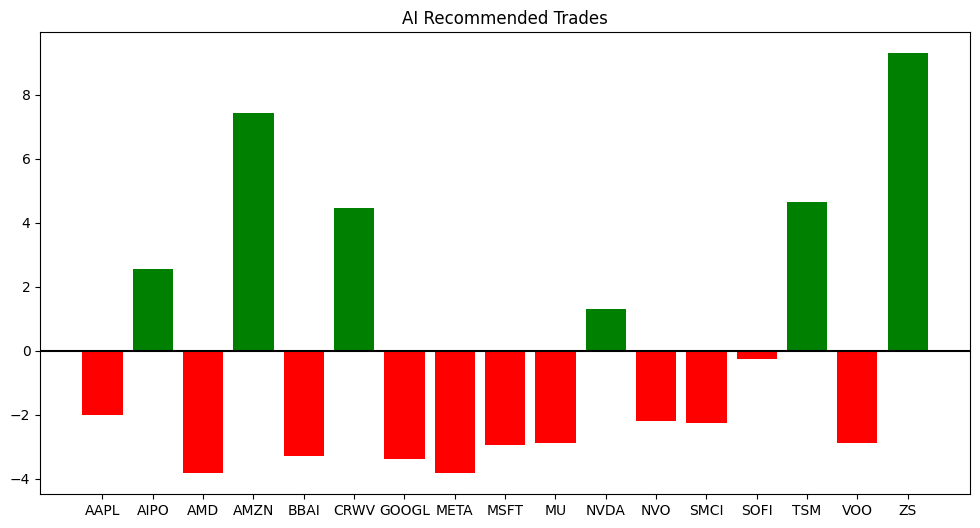

In [17]:
# 1. Get Last 30 Days of BOTH datasets
last_30_ret = log_returns.iloc[-30:].values
last_30_rsi = rsi_data.iloc[-30:].values

# 2. Create Observation (Matches Cell 5 Keys)
obs = {
    "returns": last_30_ret.reshape(1, 30, len(tickers)),
    "rsi": last_30_rsi.reshape(1, 30, len(tickers)),
    "weights": current_weights_array.reshape(1, len(tickers))
}

# 3. Predict
action, _ = model.predict(obs)

# 4. Decode
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

target_weights = softmax(action[0])

# 5. Show Plan
df_plan = pd.DataFrame({
    'Ticker': tickers,
    'Current %': current_weights_array * 100,
    'Target %': target_weights * 100,
    'Action': (target_weights - current_weights_array) * 100
})

trades = df_plan[np.abs(df_plan['Action']) > 0.5].sort_values(by='Target %', ascending=False)
print(trades.round(2))

plt.figure(figsize=(12, 6))
plt.bar(df_plan['Ticker'], df_plan['Action'], color=['g' if x>0 else 'r' for x in df_plan['Action']])
plt.title("AI Recommended Trades")
plt.axhline(0, color='black')
plt.show()

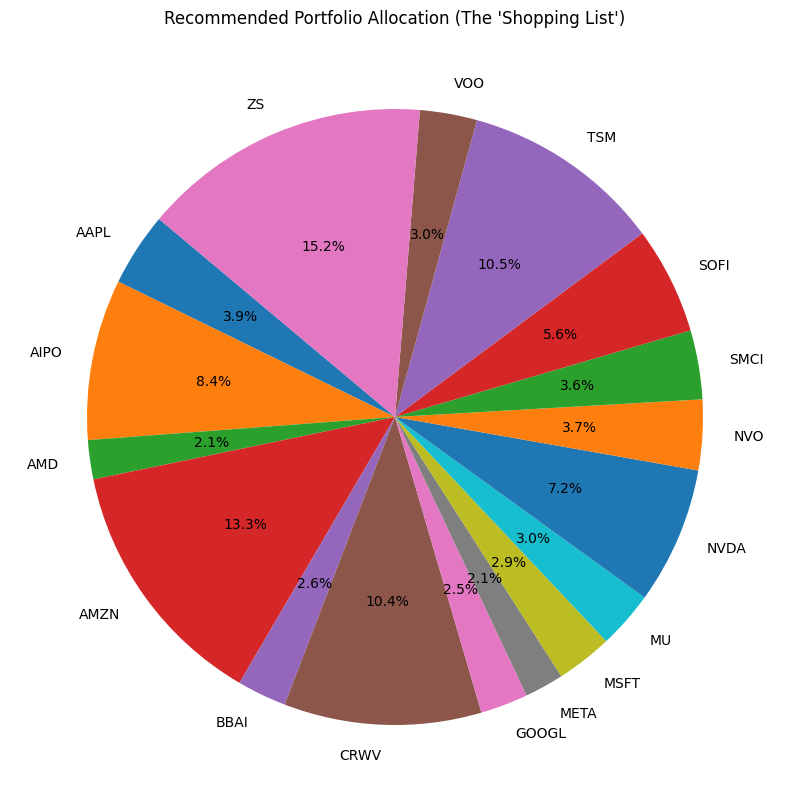

In [18]:
# Create a Pie Chart of the Target Allocation
# We filter out tiny holdings (< 1%) so the chart is readable
pie_data = df_plan[df_plan['Target %'] > 1.0]

plt.figure(figsize=(10, 10))
plt.pie(pie_data['Target %'], labels=pie_data['Ticker'], autopct='%1.1f%%', startangle=140)
plt.title("Recommended Portfolio Allocation (The 'Shopping List')")
plt.show()